# Embedding the Cosmos

## Introduction

This project aims to develop a sophisticated neural network model capable of generating meaningful representations (embeddings) of celestial coordinates. By leveraging deep space images from surveys such as the Hyper Suprime-Cam (HSC) and the Ultraviolet Near-Infrared Optical Survey (UNIONS), we aspire to create a model that understands the intricate makeup of the night sky.

## Objectives

1. **Create Embeddings:** Generate embeddings for celestial positions based on Right Ascension (RA), Declination (Dec), and other relevant metadata such as wavelength and exposure time.
2. **Generalization:** Generalize the model to unseen parts of the sky, enabling predictions for regions not covered by existing observations.
3. **Downstream Tasks:** Utilize the embeddings for various downstream tasks such as querying for rare objects, redshift estimation, and classification.

## Method

To achieve our objectives, we propose a novel approach that combines the strengths of coordinate embeddings and vision transformer models:

1. **Encoding Celestial Coordinates and Metadata:**
   - Each set of RA and Dec is encoded into a vector. This vector serves as the embedding for that specific location and image band.
   - The encoding process involves normalizing the input data to ensure consistent scaling (accommodating the spherical nature of the coordinates) and utilizing embedding layers to transform the coordinates and metadata into a high-dimensional feature space.
      - The RA and Dec are encoded through the [location encoder](https://github.com/teaghan/sky_embeddings/blob/main/utils/location_encoder.py).   

2. **Vision Transformer Decoder:**
   - We employ a vision transformer decoder model, which uses self-attention mechanisms to process the embeddings of celestial coordinates and metadata.
   - The metadata (such as band wavelength, etc.) for each image is encoded into an embedding that is the same size as the embedding for the pixelated RA and Dec values, which is then concatenated with the RA and Dec embeddings.
   - The transformer model is designed to predict the pixel values for a given region of the sky by combining the information from individual pixel embeddings and their spatial context.
   - In the transformer decoder, each pixel embedding communicates with the embeddings of nearby pixels through self-attention layers. This allows the model to capture the spatial relationships and interactions between neighboring pixels, leveraging the contextual information to improve prediction accuracy.
   - This approach allows the model to learn from observed parts of the sky and potentially generalize to unseen regions (or image bands), as it relies on the encoded coordinates and metadata rather than raw pixel data.

3. **Training and Prediction:**
   - The model is trained on a diverse set of deep space images from various surveys, with the goal of minimizing the difference between predicted and actual pixel values.
   - During training, the vision transformer decoder learns to combine the embeddings of surrounding pixels to generate accurate predictions for the entire image. The self-attention mechanism ensures that the model captures the relevant spatial dependencies and contextual information.
   - At inference time, the model can predict pixel values for any given RA and Dec coordinates, potentially even in regions not previously observed by a given survey.
   - The learned embeddings can then be used for downstream tasks such as redshift prediction.

## Implementation Plan

1. **Data Preparation:** 
   - Extract RA, Dec, and metadata for each pixel in the training images.
   - Normalize and preprocess the data to ensure consistency.
      - To mitigate the issue of pixel resolution and exposure time, the pixel values should be normalized to be in units comparable to photons/s/cm^2

2. **Model Architecture:** 
   - A location encoder for RA and Dec.
   - A separate branch of the enocder will be used for the metadata, which will then be concatenated with the location encoding.
   - A vision transformer decoder that combines the embeddings from nearby pixels to predict the pixel values.

3. **Training and Evaluation:** 
   - Train the model on a diverse set of images from multiple surveys.
   - Evaluate the model's performance on regions that were not included in training.
   - Perform downstream tasks.

In [1]:
# Code for our model.py

from functools import partial
from collections import defaultdict

import torch
import torch.nn as nn
import timm.optim.optim_factory as optim_factory
from timm.models.vision_transformer import PatchEmbed, Block
from timm.layers import AttentionPoolLatent

import os
import sys
cur_dir = ''#os.path.dirname(__file__)
sys.path.append(cur_dir)
from utils.pos_embed import get_2d_sincos_pos_embed
from utils.misc import str2bool
from utils.location_encoder import LocationEncoder

def build_model(config, model_filename, device, build_optimizer=False):
    """
    Build and initialize the model based on the provided configuration.

    Args:
        config (dict): Configuration dictionary containing model and training parameters.
        model_filename (str): Path to the file where the model state is saved.
        device (torch.device): Device on which to run the model (e.g., 'cuda' or 'cpu').
        build_optimizer (bool): Whether to build the optimizer and scheduler.

    Returns:
        tuple: If build_optimizer is True, returns the model, losses, current iteration, 
               optimizer, and scheduler. Otherwise, returns the model, losses, and current iteration.
    """
    # Model architecture parameters
    img_size = int(config['ARCHITECTURE']['img_size'])
    pixel_mean = float(config['ARCHITECTURE']['pixel_mean'])
    pixel_std = float(config['ARCHITECTURE']['pixel_std'])
    model_type = config['ARCHITECTURE']['model_type']
    loss_fn = config['TRAINING']['loss_fn']

    if model_type == 'base':
        model = base_model(img_size=img_size,
                           loss_fn=loss_fn,
                           pixel_mean=pixel_mean,
                           pixel_std=pixel_std, 
                           meta_dim=meta_dim)

    model.to(device)

    # Use multiple GPUs if available
    model = nn.DataParallel(model)

    if build_optimizer:
        # Training parameters
        total_batch_iters = int(float(config['TRAINING']['total_batch_iters']))
        weight_decay = float(config['TRAINING']['weight_decay'])
        init_lr = float(config['TRAINING']['init_lr'])
        final_lr_factor = float(config['TRAINING']['final_lr_factor'])
        
        # Set weight decay to 0 for bias and norm layers
        param_groups = optim_factory.param_groups_weight_decay(model, weight_decay)

        # Optimizer
        optimizer = torch.optim.AdamW(param_groups, lr=init_lr, betas=(0.9, 0.95))

        # Learning rate scheduler
        lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 
                                                                  int(total_batch_iters), 
                                                                  eta_min=init_lr / final_lr_factor)

        # Load model state if available
        model, losses, cur_iter = load_model(model, model_filename, optimizer, lr_scheduler)
        
        return model, losses, cur_iter, optimizer, lr_scheduler
    else:
        # Load model state if available
        model, losses, cur_iter = load_model(model, model_filename)
        return model, losses, cur_iter


def load_model(model, model_filename, optimizer=None, lr_scheduler=None):
    """
    Load the model state from a checkpoint file if it exists.

    Args:
        model (nn.Module): The model to load the state into.
        model_filename (str): Path to the checkpoint file.
        optimizer (torch.optim.Optimizer, optional): The optimizer to load the state into.
        lr_scheduler (torch.optim.lr_scheduler._LRScheduler, optional): The learning rate scheduler to load the state into.

    Returns:
        tuple: The model, losses dictionary, and current iteration.
    """
    if os.path.exists(model_filename):
        print('\nLoading saved model weights...')
        
        # Load model info
        checkpoint = torch.load(model_filename, map_location=lambda storage, loc: storage)
        losses = defaultdict(list, dict(checkpoint['losses']))
        cur_iter = checkpoint['batch_iters'] + 1

        # Load optimizer and scheduler states if provided
        if optimizer is not None:
            optimizer.load_state_dict(checkpoint['optimizer'])
        if lr_scheduler is not None:
            lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
        
        # Load model weights
        model.module.load_state_dict(checkpoint['model'])
    else:
        print('\nStarting fresh model to train...')
        losses = defaultdict(list)
        cur_iter = 1
        
    return model, losses, cur_iter

class CosmosViT(nn.Module):
    """
    CosmosViT is a neural network model for generating embeddings of celestial coordinates 
    and metadata, and using these embeddings to predict pixel values for regions of the sky.

    Attributes:
        img_size (int): The size of the input image (assumed to be square).
        embed_dim (int): The dimension of the embedding space.
        decoder_embed_dim (int): The dimension of the embedding space in the decoder.
        decoder_depth (int): The number of layers in the transformer decoder.
        decoder_num_heads (int): The number of attention heads in the transformer decoder.
        mlp_ratio (float): The ratio of the MLP dimension to the embedding dimension.
        norm_layer (nn.Module): The normalization layer.
        loss_fn (str): The loss function to use ('mse' or 'l1').
        pixel_mean (float): The mean pixel value for normalization.
        pixel_std (float): The standard deviation of pixel values for normalization.
        num_meta (int): The dimension of the metadata.
        meta_mean (list): The mean values for each metadata variable.
        meta_std (list): The standard deviations for each metadata variable.
    """
    def __init__(self, img_size=64, embed_dim=1024,
                 decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
                 mlp_ratio=4., norm_layer=nn.LayerNorm,
                 loss_fn='mse', pixel_mean=0, pixel_std=1., num_meta=0,
                 meta_mean=None, meta_std=None):
        super().__init__()

        # Initialize attributes
        self.img_size = img_size
        self.loss_fn = loss_fn
        self.pixel_mean = pixel_mean
        self.pixel_std = pixel_std
        self.num_meta = num_meta
        self.meta_mean = torch.tensor(meta_mean) if meta_mean is not None else torch.zeros(num_meta)
        self.meta_std = torch.tensor(meta_std) if meta_std is not None else torch.ones(num_meta)
        if num_meta > 0:
            self.num_extra_tokens = 2
        else:
            self.num_extra_tokens = 1

        self.num_pixels = int(img_size ** 2)
        
        # Initialize RA/Dec encoder
        self.ra_dec_embed = LocationEncoder(neural_network_name="siren", 
                                            legendre_polys=5,
                                            dim_hidden=8,
                                            num_layers=3,
                                            num_classes=embed_dim)

        if num_meta > 0:
            # Initialize metadata encoder
            self.meta_embed = nn.Sequential(
                nn.Linear(num_meta, embed_dim // 2),
                nn.ReLU(),
                nn.Linear(embed_dim // 2, embed_dim)
            )

        # Initialize class token, normalization layer, and decoder embedding
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.norm = norm_layer(embed_dim)
        self.decoder_embed = nn.Linear(embed_dim, decoder_embed_dim, bias=True)
        self.decoder_pos_embed = nn.Parameter(torch.zeros(1, self.num_pixels + self.num_extra_tokens, 
                                                          decoder_embed_dim), requires_grad=False)
        self.decoder_blocks = nn.ModuleList([
            Block(decoder_embed_dim, decoder_num_heads, mlp_ratio, qkv_bias=True, norm_layer=norm_layer)
            for _ in range(decoder_depth)])
        self.decoder_norm = norm_layer(decoder_embed_dim)
        self.decoder_pred = nn.Linear(decoder_embed_dim, 1, bias=True)

        # Initialize weights
        self.initialize_weights()

    def initialize_weights(self):
        """Initialize weights for positional embeddings and other layers."""
        decoder_pos_embed = get_2d_sincos_pos_embed(self.decoder_pos_embed.shape[-1], 
                                                    int(self.num_pixels ** 0.5), 
                                                    cls_token=True, ra_dec=(self.num_extra_tokens > 1))
        self.decoder_pos_embed.data.copy_(torch.from_numpy(decoder_pos_embed).float().unsqueeze(0))
        torch.nn.init.normal_(self.cls_token, std=.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        """Initialize weights for linear and normalization layers."""
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            if m.elementwise_affine:
                nn.init.constant_(m.bias, 0)
                nn.init.constant_(m.weight, 1.0)

    def prepare_batch(self, ra_dec):
        """
        Reshape the input batch for the RA/Dec encoder.

        Args:
            ra_dec (torch.Tensor): Tensor containing RA and Dec coordinates.

        Returns:
            torch.Tensor: Reshaped tensor for encoding.
        """
        batch_size, _, img_size, _ = ra_dec.shape
        ra_dec = ra_dec.permute(0, 2, 3, 1).reshape(-1, 2)  # Reshape to (batch_size * img_size * img_size, 2)
        return ra_dec

    def restore_batch(self, encoded, batch_size, img_size):
        """
        Reshape

 the encoded output back to its original batch shape.

        Args:
            encoded (torch.Tensor): Encoded tensor.
            batch_size (int): The batch size.
            img_size (int): The image size.

        Returns:
            torch.Tensor: Reshaped tensor to original batch shape.
        """
        encoded = encoded.reshape(batch_size, img_size * img_size, -1)  # Reshape back to (batch_size, img_size * img_size, embed_dim)
        return encoded

    def normalize_meta(self, meta):
        """
        Normalize the metadata using the provided mean and std.

        Args:
            meta (torch.Tensor): Metadata tensor.

        Returns:
            torch.Tensor: Normalized metadata.
        """
        return (meta - self.meta_mean) / self.meta_std

    def forward_encoder(self, ra_dec):
        """
        Forward pass for the RA/Dec encoder.

        Args:
            ra_dec (torch.Tensor): Tensor containing RA and Dec coordinates.

        Returns:
            torch.Tensor: Encoded RA/Dec embeddings.
        """
        # Encode RA and Dec
        ra_dec_embed = self.ra_dec_embed(ra_dec)
        ra_dec_embed = self.norm(ra_dec_embed)
        return ra_dec_embed

    def forward_decoder(self, x, meta=None, return_cls=False):
        """
        Forward pass for the decoder, including optional metadata.

        Args:
            x (torch.Tensor): Latent embeddings of RA/Dec coordinates.
            meta (torch.Tensor, optional): Metadata tensor.
            return_cls (bool): Whether to return class token projection.

        Returns:
            torch.Tensor: Predicted pixel values or class token projection.
        """
        if meta is not None:
            # Normalize metadata
            meta = self.normalize_meta(meta)

            # Encode metadata
            meta_embeds = self.meta_embed(meta)

            # Aggregate embeddings (simple concatenation and linear layer)
            x = torch.cat((meta_embeds.unsqueeze(1), x), dim=1)
            x = self.norm(x)
        
        # Add class token
        cls_tokens = self.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # Project to decoder embedding space
        x = self.decoder_embed(x)
        x = x + self.decoder_pos_embed

        # Apply decoder transformer blocks
        for blk in self.decoder_blocks:
            x = blk(x)

        # Final normalization and prediction
        x = self.decoder_norm(x)
        x = self.decoder_pred(x)

        # Separate class token and reshape output
        cls_proj = x[:, 0, :]
        x = x[:, self.num_extra_tokens:, :]
        x = x.reshape(-1, 1, self.img_size, self.img_size)
        
        if return_cls:
            return x, cls_proj
        else:
            return x

    def forward_loss(self, imgs, pred):
        """
        Compute the loss between the target images and predictions.

        Args:
            imgs (torch.Tensor): Target images.
            pred (torch.Tensor): Predicted images.

        Returns:
            torch.Tensor: Computed loss.
        """
        if self.loss_fn == 'mse':
            loss = torch.nn.functional.mse_loss(imgs, pred, reduction='none')
        else:
            loss = torch.nn.functional.l1_loss(imgs, pred, reduction='none')
        
        # Handle NaNs in the loss computation
        mask = torch.where(torch.isnan(loss), 0, 1)
        loss = torch.nan_to_num(loss, nan=0.0)
        avg_scale_factor = mask.sum() / mask.numel() * loss.numel()
        loss = (loss * mask).sum() / (avg_scale_factor + 1e-5)
        return loss

    def norm_imgs(self, x):
        """
        Normalize the images.

        Args:
            x (torch.Tensor): Images to normalize.

        Returns:
            torch.Tensor: Normalized images.
        """
        return (x - self.pixel_mean) / self.pixel_std

    def denorm_imgs(self, orig_imgs, x):
        """
        Denormalize the images.

        Args:
            orig_imgs (torch.Tensor): Original images.
            x (torch.Tensor): Images to denormalize.

        Returns:
            torch.Tensor: Denormalized images.
        """
        return x * self.pixel_std + self.pixel_mean

    def forward(self, ra_dec, tgt_imgs, meta=None):
        """
        Forward pass through the entire model.

        Args:
            ra_dec (torch.Tensor): Tensor containing RA and Dec coordinates.
            tgt_imgs (torch.Tensor): Target images.
            meta (torch.Tensor, optional): Metadata tensor.

        Returns:
            tuple: Computed loss and predicted images.
        """
        # Prepare the RA/Dec batch
        batch_size, _, img_size, _ = ra_dec.shape
        ra_dec = self.prepare_batch(ra_dec)

        # Encode RA/Dec
        latent = self.forward_encoder(ra_dec)

        # Restore batch shape for latent embeddings
        latent = self.restore_batch(latent, batch_size, img_size)

        # Decode with optional metadata
        pred = self.forward_decoder(latent, meta=meta)

        # Normalize target images and compute loss
        tgt_imgs = self.norm_imgs(tgt_imgs)
        loss = self.forward_loss(tgt_imgs.detach(), pred)
        return loss, pred

def base_model(**kwargs):
    """
    Build the base model.

    Returns:
        CosmosViT: An instance of the CosmosViT model.
    """
    model = CosmosViT(
        embed_dim=768,
        decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model

In [2]:
img_size=16
loss_fn='l1'
pixel_mean=0
pixel_std=1
num_meta = 2
meta_mean = [6177, 8428]
meta_std = [1812, 1701]

model = base_model(img_size=img_size,
                   loss_fn=loss_fn,
                   pixel_mean=pixel_mean,
                   pixel_std=pixel_std, 
                   num_meta=num_meta,
                  meta_mean=meta_mean, meta_std=meta_std)

# Data Loading Procedure for "Embedding the Cosmos"

## Overview

The data loading procedure is designed to handle astronomical image data from FITS files. It prepares the data for training a neural network to generate embeddings of celestial coordinates and metadata. The process involves finding and loading FITS files, generating random cutouts, and batching the data.

## Steps

### 1. Building the DataLoader

The `build_fits_dataloader` function creates a DataLoader for FITS files. It accepts parameters such as file paths, color bands, batch size, and more, and returns a DataLoader that can be used during training.

### 2. Finding FITS Files

The `find_HSC_files` function searches for FITS files from the Hyper Suprime-Cam (HSC) survey across specified directories. It filters files based on the required color bands and optionally includes files with a 'calexp-' prefix.

### 3. Loading FITS Data

The `load_fits` function loads data from a specified FITS file. It extracts image data, metadata, and optionally, RA/Dec coordinates using World Coordinate System (WCS) transformations. The function ensures robustness by handling exceptions and continuing to load other data even if some files cannot be opened.

### 4. Generating Random Cutouts

The `random_cutouts` function generates random cutouts from the loaded FITS images. It ensures each cutout is of the specified size and extracts corresponding RA/Dec values if available. This step helps to create diverse training samples.

### 5. Creating the FitsDataset Class

The `FitsDataset` class is a custom PyTorch dataset designed for loading and processing FITS files. It manages the following tasks:
- Initializing with parameters such as file paths, color bands, metadata keys, image size, and batch size.
- Finding relevant FITS files using the `find_HSC_files` function.
- Implementing the `__getitem__` method to load FITS data, generate random cutouts, clip pixel values, and convert the data to PyTorch tensors. It also batches the data for efficient loading during training.

In [3]:
import random
import numpy as np
import torch
import h5py
import torchvision
torchvision.disable_beta_transforms_warning()
from torchvision.transforms import v2
import os
import glob
from astropy.io import fits
from astropy.wcs import WCS

def build_fits_dataloader(fits_paths, bands, batch_size, num_workers, meta_keys,
                          img_size=64, cutouts_per_tile=1024, use_calexp=True,
                          shuffle=True):
    """
    Return a DataLoader for FITS files to be used during training.

    Args:
        fits_paths (list): List of paths to directories containing FITS files.
        bands (list): List of color bands to include (e.g., ['G', 'R', 'I', 'Z', 'Y']).
        batch_size (int): Number of samples per batch.
        num_workers (int): Number of worker threads for data loading.
        meta_keys (list): List of metadata keys to extract.
        img_size (int, optional): Size of the square cutouts to generate. Defaults to 64.
        cutouts_per_tile (int, optional): Number of cutouts to generate from each FITS tile. Defaults to 1024.
        use_calexp (bool, optional): Whether to include files with 'calexp-' prefix. Defaults to True.
        shuffle (bool, optional): Whether to shuffle the dataset. Defaults to True.

    Returns:
        torch.utils.data.DataLoader: DataLoader for the FITS dataset.
    """
    
    # Build dataset
    dataset = FitsDataset(fits_paths, 
                          bands=bands, img_size=img_size, 
                          meta_keys=meta_keys,
                          cutouts_per_tile=cutouts_per_tile,
                          batch_size=batch_size,
                          use_calexp=use_calexp)

    # Build dataloader
    return torch.utils.data.DataLoader(dataset, batch_size=1, 
                                       shuffle=shuffle, num_workers=num_workers,
                                       drop_last=True, pin_memory=True)

def find_HSC_files(fits_paths, bands, verbose=1, use_calexp=True):
    """
    Searches for HSC (Hyper Suprime-Cam) survey FITS files across specified paths.

    Args:
        fits_paths (list): Paths to search for HSC FITS files.
        bands (list): Color bands to search for (e.g., ['G', 'R', 'I', 'Z', 'Y']).
        verbose (int, optional): Verbosity level. Defaults to 1.
        use_calexp (bool, optional): Whether to include files with 'calexp-' prefix. Defaults to True.

    Returns:
        list: A list of file paths for the bands found for all patches.
    """
    
    patch_files = []  # List to store available file names

    for fits_path in fits_paths:
        fits_files = glob.glob(f"{fits_path}/*.fits")

        for file_path in fits_files:
            file_name = file_path.split('/')[-1]  # Extract just the filename
            # Determine if file matches the calexp condition
            if (use_calexp and file_name.startswith('calexp-')) or (not use_calexp and not file_name.startswith('calexp-')):
                # Extract band and patch identifier from the filename
                parts = file_name.split('-')
                if len(parts) < 3:
                    continue
                band = parts[-3]
                patch = '-'.join(parts[-2:])
                
                if band in bands:
                    patch_files.append(file_path)

    if verbose:
        print(f"Found {len(patch_files)} fits files with the {bands} bands.")

    return patch_files

def load_fits(patch_filename, return_wc=False, meta_keys=[[5,'wavelengthMin'],[5,'wavelengthMax']]):
    """
    Load data from a FITS file.

    Args:
        patch_filename (str): Filename of the FITS file to be loaded. Filenames should be full paths.
        return_wc (bool, optional): Whether to return world coordinates (RA, Dec). Defaults to False.
        meta_keys (list, optional): List of metadata keys to extract. Defaults to [[5,'wavelengthMin'],[5,'wavelengthMax']].

    Returns:
        tuple: A tuple containing the image data, metadata, and RA/Dec coordinates (if return_wc is True).
    """
    meta_data = []
    ra_dec = None

    try:
        # Attempt to open the FITS file
        with fits.open(patch_filename, mode='readonly', ignore_missing_simple=True) as hdul:
            img = hdul[1].data

            # Collect Meta data
            for m in meta_keys:
                meta_data.append(hdul[m[0]].data[m[1]])

            # Collect pixel to world coord
            if return_wc:
                wcs = WCS(hdul[1].header)
                # Collect RA and Dec at each pixel
                H, W = img.shape
                x_indx = np.arange(0, H).astype(int)
                y_indx = np.arange(0, W).astype(int)
                x_indx, y_indx = np.meshgrid(x_indx, y_indx, indexing='xy')  
                ra, dec = wcs.all_pix2world(x_indx, y_indx, 0)
                ra_dec = np.array((ra, dec))
                        
    except Exception as e:
        # Handle the case where the FITS file cannot be opened
        print(f"Error opening {patch_filename}: {e}")
        img = np.full((4100,4200), np.nan)

    # Organize into (H, W) and convert to a single NumPy array
    return img, np.array(meta_data).flatten(), ra_dec
    
def random_cutouts(input_array, img_size, n_cutouts, ra_dec=None):
    """
    Generate random cutouts from a larger 3D numpy array.

    Args:
        input_array (numpy.ndarray): The larger 3D numpy array of shape (H, W).
        img_size (int): The desired size of each cutout in both height and width.
        n_cutouts (int): The number of random cutouts to generate.
        ra_dec (numpy.ndarray, optional): The RA/Dec coordinates corresponding to the input array.

    Returns:
        tuple: A tuple containing the cutouts and corresponding RA/Dec coordinates.
    """
    H, W = input_array.shape
    # Pre-allocate numpy array for efficiency
    cutouts = np.zeros((n_cutouts, 1, img_size, img_size), dtype=input_array.dtype)
    ra_decs = np.zeros((n_cutouts, 2, img_size, img_size), dtype=input_array.dtype)

    # Generate random coordinates for all cutouts in a batch
    h_starts = np.random.randint(0, H - img_size + 1, size=n_cutouts)
    w_starts = np.random.randint(0, W - img_size + 1, size=n_cutouts)
    
    for i, (h_start, w_start) in enumerate(zip(h_starts, w_starts)):
        # Fill the pre-allocated arrays directly
        cutouts[i, 0] = input_array[h_start:h_start + img_size, w_start:w_start + img_size]
        ra_decs[i] = ra_dec[:, h_start:h_start + img_size, w_start:w_start + img_size]

    return cutouts, ra_decs
    
class FitsDataset(torch.utils.data.Dataset):
    """
    A PyTorch dataset class for loading astronomical image data from FITS files.

    This class is designed to handle multi-band astronomical images and generate cutouts of a specified size.
    It supports dynamic mask generation, pixel value clipping, and custom transformations.

    Args:
        fits_paths (list): List of directories containing the FITS files.
        bands (list, optional): List of color bands to include in the dataset. Defaults to ['G', 'R', 'I', 'Z', 'Y'].
        meta_keys (list, optional): List of metadata keys to extract. Defaults to [[5,'wavelengthMin'],[5,'wavelengthMax']].
        img_size (int, optional): Size of the square cutouts to generate. Defaults to 64.
        cutouts_per_tile (int, optional): Number of cutouts to generate from each FITS tile. Defaults to 1024.
        batch_size (int, optional): Number of cutouts per batch. Defaults to 64.
        pixel_min (float, optional): Minimum pixel value for clipping. Defaults to -3.
        pixel_max (float, optional): Maximum pixel value for clipping. If None, no upper clipping is applied. Defaults to None.
        use_calexp (bool, optional): Whether to include files with 'calexp-' prefix. Defaults to True.

    Attributes:
        fits_paths (list): List of directories containing the FITS files.
        meta_keys (list): List of metadata keys to extract.
        img_size (int): Size of the square cutouts to generate.
        cutouts_per_tile (int): Number of cutouts to generate from each FITS tile.
        batch_size (int): Number of cutouts per batch.
        pixel_min (float): Minimum pixel value for clipping.
        pixel_max (float): Maximum pixel value for clipping.
        use_calexp (bool): Whether to include files with 'calexp-' prefix.
        fits_filenames (list): List of FITS file paths found based on the provided parameters.

    Methods:
        __len__(): Returns the total number of FITS tiles with all requested bands available.
        __getitem__(idx): Returns a batch of cutouts and their corresponding masks (if mask generation is enabled) from the FITS tile at the specified index.
    """

    def __init__(self, fits_paths, bands=['G','R','I','Z','Y'], 
                 meta_keys=[[5,'wavelengthMin'],[5,'wavelengthMax']],
                 img_size=64, cutouts_per_tile=1024, batch_size=64,
                 pixel_min=-3., pixel_max=None, use_calexp=True):
        
        self.fits_paths = fits_paths
        self.meta_keys = meta_keys
        self.img_size = img_size
        self.cutouts_per_tile = cutouts_per_tile
        self.batch_size = batch_size
        self.pixel_min = pixel_min
        self.pixel_max = pixel_max
        self.use_calexp = use_calexp

        # Find names of patch fits files
        self.fits_filenames = find_HSC_files(fits_paths, bands, use_calexp=use_calexp)
                        
    def __len__(self):
        """
        Returns the number of FITS patches with all of the requested bands.

        Returns:
            int: Number of FITS patches.
        """
        return len(self.fits_filenames)
    
    def __getitem__(self, idx):
        """
        Returns a batch of cutouts and their corresponding metadata and RA/Dec coordinates.

        Args:
            idx (int): Index of the FITS tile to load.

        Returns:
            tuple: A tuple containing the cutouts, RA/Dec coordinates, and metadata.
        """
        # Grab fits filenames
        patch_filename = self.fits_filenames[idx]
        
        # Load patch of sky
        cutouts, meta_data, ra_dec = load_fits(patch_filename, return_wc=True, 
                                                     meta_keys=self.meta_keys)

        # Select random cutouts
        cutouts, ra_dec = random_cutouts(cutouts, self.img_size, self.cutouts_per_tile, ra_dec)
        
        # Clip pixel values
        if self.pixel_min is not None:
            cutouts[cutouts < self.pixel_min] = self.pixel_min
        if self.pixel_max is not None:
            cutouts[cutouts > self.pixel_max] = self.pixel_max

        # Convert to PyTorch tensors
        cutouts = torch.from_numpy(cutouts).to(torch.float32)
        ra_dec = torch.from_numpy(ra_dec).to(torch.float32)
        meta_data = torch.from_numpy(meta_data).to(torch.float32)
        meta_data = meta_data.unsqueeze(0).repeat(len(cutouts), 1)
        
        # Sort into M batches of batch_size
        M = cutouts.shape[0] // self.batch_size
        cutouts = cutouts[:M * self.batch_size].reshape((M, self.batch_size, 1, self.img_size, self.img_size))
        ra_dec = ra_dec[:M * self.batch_size].reshape((M, self.batch_size, 2, self.img_size, self.img_size))
        meta_data = meta_data[:M * self.batch_size].reshape((M, self.batch_size, -1))
        
        return cutouts, ra_dec, meta_data

fits_paths = ['/arc/projects/ots/pdr3_dud/']
meta_keys = [[5,'wavelengthMin'],[5,'wavelengthMax']]
bands=['G','R','I','Z','Y']
cutouts_per_tile=128
batch_size=32
use_calexp=True
num_workers = 0

dataloader = build_fits_dataloader(fits_paths, bands, batch_size, num_workers, meta_keys,
                                  img_size=img_size, cutouts_per_tile=cutouts_per_tile, use_calexp=use_calexp,
                                  shuffle=True)

Found 7514 fits files with the ['G', 'R', 'I', 'Z', 'Y'] bands.


In [4]:
def get_train_samples(dataloader, train_nested_batches):
    '''Accomodates both dataloaders.'''
    if train_nested_batches:
        # Iterate through all of the tiles
        for sample_batches, ra_decs, metas in dataloader:
            # Iterate through each batch of images in this tile of the sky
            for samples, ra_dec, meta in zip(sample_batches[0], ra_decs[0], metas[0]):
                yield samples, ra_dec, meta
    else:
        for samples, ra_dec, meta in dataloader:
            yield samples, ra_dec, meta

# Iterate through training dataset
for samples, ra_decs, metas in get_train_samples(dataloader, True):
    im = model.forward(ra_decs, samples, meta=metas)
    break

In [5]:
samples.shape, ra_decs.shape, metas.shape, im[1].shape

(torch.Size([32, 1, 16, 16]),
 torch.Size([32, 2, 16, 16]),
 torch.Size([32, 2]),
 torch.Size([32, 1, 16, 16]))

## Rough work

- wavelengthMin: `hdul[5].data['wavelengthMin']`
- wavelengthMax: `hdul[5].data['wavelengthMax']`

In [ ]:
meta_mean = [6177, 8428]
meta_std = [1812, 1701]

In [14]:
np.mean(np.unique(wmax)), np.std(np.unique(wmax))

(8428.039999999999, 1701.4976821612188)

In [13]:
np.mean(np.array([3803.5, 5000.6, 5003.8, 6251.8, 8002.1, 9000.6])), np.std(np.array([3803.5, 5000.6, 5003.8, 6251.8, 8002.1, 9000.6]))#np.unique(wmin)

(6177.066666666667, 1812.1405130091014)

In [7]:
wmin = []
wmax = []
for fn in dataloader.dataset.fits_filenames:
    hdul = fits.open(fn, mode='readonly', ignore_missing_simple=True)

    wmin.append(hdul[5].data['wavelengthMin'])
    wmax.append(hdul[5].data['wavelengthMax'])

KeyboardInterrupt: 

In [56]:
fn  = dataloader.dataset.fits_filenames[0]


with fits.open(fn, mode='readonly', ignore_missing_simple=True) as hdul:
    wcs = WCS(hdul[1].header)
    NAXIS1 = hdul[1].header['NAXIS1'] 
    NAXIS2 = hdul[1].header['NAXIS2']
    upper_left = wcs.pixel_to_world(0, 0)
    lower_right = wcs.pixel_to_world(NAXIS2, NAXIS1)
    # Return function for determining RA and Dec from pixel coords
    def pix_to_radec(x, y):
        # The ordering of the axes in the fits files is a bit 
        # confusing to me, but I'm pretty sure this is right...
        return wcs.all_pix2world(x, y, 0)

    img = hdul[1].data


In [64]:
H, W = img.shape

# Collect RA and Dec at each pixel
x_indx = np.arange(0, H).astype(int)
y_indx = np.arange(0, W).astype(int)
x_indx, y_indx = np.meshgrid(x_indx, y_indx, indexing='xy')

# Collect RA and Dec at centre of each cutout
ra, dec = pix_to_radec(x_indx, y_indx)

In [65]:
upper_left

<SkyCoord (ICRS): (ra, dec) in deg
    (242.99551146, 54.94519885)>

In [66]:
ra[0,0], dec[0,0]

(242.99551146269786, 54.945198847047266)

In [67]:
lower_right

<SkyCoord (ICRS): (ra, dec) in deg
    (242.66320108, 55.14206379)>

In [68]:
ra[-1,-1], dec[-1,-1]

(242.66328253066243, 55.14201702730726)

In [54]:
lower_left.ra.deg, upper_right.ra.deg

(242.99551146269786, 242.6550190462025)

In [55]:
lower_left.dec.deg, upper_right.dec.deg

(54.945198847047266, 55.13740878489209)

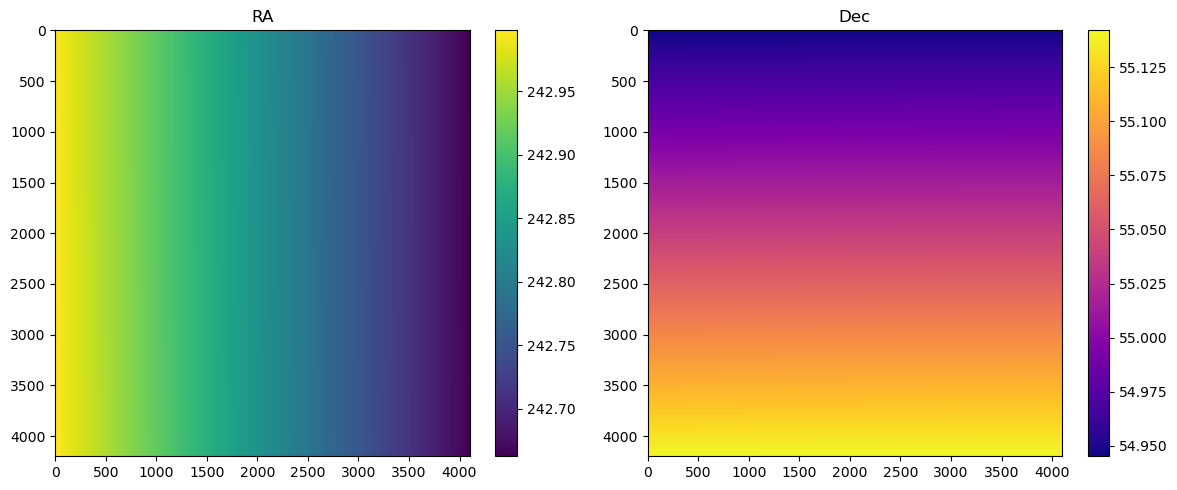

In [40]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot the 'ra' array
im1 = axs[0].imshow(ra, aspect='auto', cmap='viridis')
axs[0].set_title('RA')
fig.colorbar(im1, ax=axs[0], orientation='vertical')

# Plot the 'dec' array
im2 = axs[1].imshow(dec, aspect='auto', cmap='plasma')
axs[1].set_title('Dec')
fig.colorbar(im2, ax=axs[1], orientation='vertical')

plt.tight_layout()
plt.show()